In [54]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from adjustText import adjust_text

import nfl_data_py as nfl


In [2]:
# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

In [3]:
years = range(1999, 2023)

In [4]:
data = nfl.import_pbp_data(years, cache=True, alt_path="../cache")

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [25]:
picks = nfl.import_draft_picks(years)

In [26]:
picks = picks[['season', 'team', 'position', 'round', 'pfr_player_name']]

In [27]:
# Keep only the rows where the position is RB and the round is less than or equal to 5
picks = picks[(picks['position'] == 'RB') & (picks['round'] <= 5)]

In [28]:
picks = picks.rename(columns={'season': 'draft year', 'pfr_player_name': 'rusher_player_name'})

In [29]:
# Split the name into a list
name_split = picks['rusher_player_name'].str.split()

# Take the first character of the first name and combine it with the last name
# If there's a third part (like "Jr."), ignore it
picks['rusher_player_name'] = name_split.apply(
    lambda x: x[0][0] + '.' + x[1] if len(x) > 2 else x[0][0] + '.' + x[-1])

In [118]:
df = data[['season', 'posteam', 'play_type', 'epa', 'season_type']]

In [119]:
df = df[(df['season_type'] == 'REG') & (df['play_type'] == 'run')]

In [120]:
# group by season and team and add a column for epa/rush and epa/rush for the next season
df = df.groupby(['season', 'posteam'])\
    .agg({'epa': 'mean'})\
        .reset_index()\
            .rename(columns={'epa': 'team epa/rush', 'posteam': 'team'})

In [124]:
# add a column for epa/rush rank within the season and the epa/rush rank for the next season
df['team epa/rush rank'] = df.groupby('season')['team epa/rush'].rank(ascending=False)

df['team epa/rush rank next season'] = df.groupby('team')['team epa/rush rank'].shift(-1)

In [125]:
# Keep only the bottom 5 teams in epa/rush for each year
df = df.groupby('season')\
    .apply(lambda x: x.nsmallest(5, 'team epa/rush'))\
        .reset_index(drop=True)

In [126]:
df[df['season'] == 2022]


,season,team,team epa/rush,team epa/rush rank,team epa/rush rank next season
115,2022,TB,-0.205172,32.0,NaN
116,2022,HOU,-0.185692,31.0,NaN
117,2022,IND,-0.148543,30.0,NaN
118,2022,MIN,-0.101831,29.0,NaN
119,2022,NO,-0.100509,28.0,NaN


In [35]:
# Create a column for the draft year, which is the season + 1
df['draft year'] = df['season'] + 1

In [36]:
# Merge the draft picks and the bottom 5 teams in epa/rush
df = df.merge(picks, on=['draft year', 'team'], how='left')

In [37]:
# Create a dataframe of season, team, rusher_id, rusher_player_name, play_type, and epa
rushers = data[['season', 'posteam', 'rusher_player_name', 'play_type', 'epa', 'season_type']]

In [38]:
# Keep only the rows where the play_type is run
rushers = rushers[(rushers['season_type'] == 'REG') & (rushers['play_type'] == 'run')]

In [39]:
# Group by season, team, rusher_id, and rusher_player_name and add a column for epa/rush and # of rushes
rushers = rushers.groupby(['season', 'posteam', 'rusher_player_name'])\
    .agg({'epa': 'mean', 'play_type': 'count'})\
        .reset_index()\
            .rename(columns={'epa': 'rusher epa/rush', 'play_type': 'attempts', 'season': 'draft year', 'posteam': 'team'})


In [40]:
# inner join the two dataframes on draft year and team
df = df.merge(rushers, on=['draft year', 'team', 'rusher_player_name'], how='inner')

In [41]:
df

,season,team,team epa/rush,team epa/rush rank,team epa/rush rank next season,draft year,position,round,rusher_player_name,rusher epa/rush,attempts
0,1999,SEA,-0.221505,31.0,16.0,2000,RB,1.0,S.Alexander,-0.073311,64
1,1999,NYG,-0.187486,28.0,21.0,2000,RB,1.0,R.Dayne,-0.143458,227
2,1999,ARI,-0.185343,27.0,30.0,2000,RB,1.0,T.Jones,-0.224247,113
3,2000,CLE,-0.203082,29.0,30.0,2001,RB,3.0,J.Jackson,-0.183764,195
4,2001,CLE,-0.181118,30.0,16.0,2002,RB,1.0,W.Green,-0.127704,243
5,2003,DET,-0.152473,29.0,7.0,2004,RB,1.0,K.Jones,-0.041986,241
6,2004,CHI,-0.151501,29.0,22.0,2005,RB,1.0,C.Benson,-0.262023,67
7,2004,MIA,-0.149385,28.0,15.0,2005,RB,1.0,R.Brown,-0.071388,207
8,2005,CLE,-0.165558,31.0,30.0,2006,RB,5.0,J.Harrison,-0.241124,20
9,2005,TEN,-0.136060,28.0,8.0,2006,RB,2.0,L.White,-0.080030,61


In [42]:
# Filter both dataframes to include only where attempts is greater than 50
df = df[df['attempts'] > 50]

rushers = rushers[rushers['attempts'] > 50]

In [43]:
rushers

,draft year,team,rusher_player_name,rusher epa/rush,attempts
0,1999,ARI,A.Murrell,-0.244678,192
5,1999,ARI,M.Bates,0.037864,72
6,1999,ARI,M.Pittman,-0.180480,63
10,1999,ATL,B.Hanspard,-0.289550,136
13,1999,ATL,K.Oxendine,-0.231119,138
...,...,...,...,...,...
7901,2022,TB,L.Fournette,-0.196427,189
7902,2022,TB,R.White,-0.138132,130
7906,2022,TEN,D.Henry,-0.063929,349
7916,2022,WAS,A.Gibson,-0.105297,149


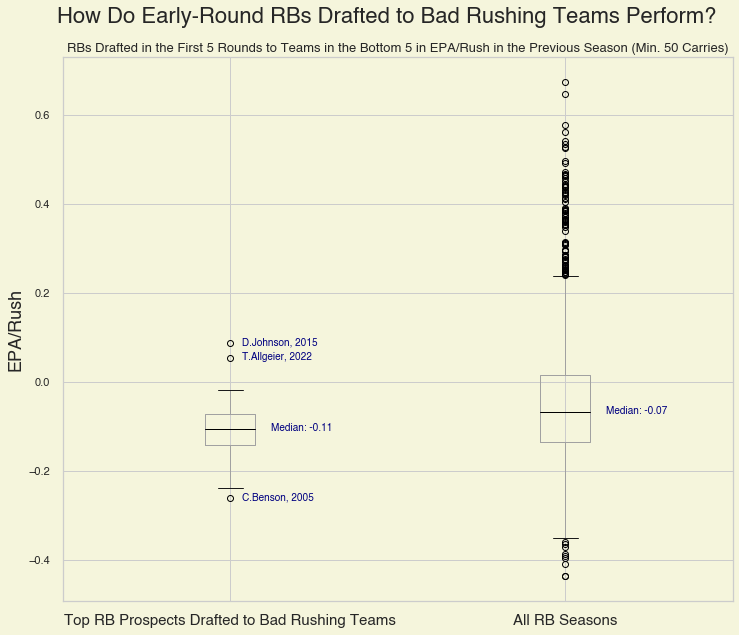

In [98]:
from adjustText import adjust_text

# Define custom font
font = {'family': 'Helvetica',
        'weight': 'bold',
        'size': 18}  # Increase the font size
mpl.rc('font', **font)

# Create a new dataframe for the boxplot
boxplot_data = pd.DataFrame(
    {'Top RB Prospects Drafted to Bad Rushing Teams': df['rusher epa/rush'],
     'All RB Seasons': rushers['rusher epa/rush']})

# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
bp = boxplot_data.boxplot(ax=ax, return_type='dict')

# Change color of median line to black
for median in bp['medians']:
    median.set(color='black')

# Change the background color to beige
fig.patch.set_facecolor('beige')
ax.set_facecolor('beige')

# Optional customizations
plt.suptitle('How Do Early-Round RBs Drafted to Bad Rushing Teams Perform?', fontsize=22,
             y=0.95, ha='center')  # Increase font size, adjust position and center the title
plt.title("RBs Drafted in the First 5 Rounds to Teams in the Bottom 5 in EPA/Rush in the Previous Season (Min. 50 Carries)",
          fontsize=13, y=1.0, ha='center')  # Increase font size, adjust position and center the title
plt.ylabel('EPA/Rush', fontsize=18)  # Increase font size
plt.xticks(fontsize=15)  # Increase x tick label size

# Identify and label outliers in the 'Top RB Prospects Drafted to Bad Rushing Teams' series
Q1 = boxplot_data['Top RB Prospects Drafted to Bad Rushing Teams'].quantile(
    0.25)
Q3 = boxplot_data['Top RB Prospects Drafted to Bad Rushing Teams'].quantile(
    0.75)
IQR = Q3 - Q1
outliers = boxplot_data['Top RB Prospects Drafted to Bad Rushing Teams'][
    ((boxplot_data['Top RB Prospects Drafted to Bad Rushing Teams'] < (
        Q1 - 1.5 * IQR)) |
     (boxplot_data['Top RB Prospects Drafted to Bad Rushing Teams'] > (Q3 + 1.5 * IQR)))]

# Create empty list to store the text objects for the adjust_text function
texts = []

for outlier in outliers.index:
    texts.append(ax.annotate(f"{df.loc[outlier, 'rusher_player_name']}, {df.loc[outlier, 'draft year']}",
                             (1, outliers[outlier]),
                             textcoords="offset points",  # specify coordinates as offset points from data
                             # specify x and y offset in points
                             xytext=(10, -5),
                             ha='center',  # center text horizontally
                             fontsize=10,  # smaller font size for the annotations
                             color='navy'))  # color of the annotation text

# Annotate medians
for i, median in enumerate(bp['medians']):
    texts.append(ax.annotate(f"Median: {median.get_ydata()[0]:.2f}",
                             (i+1, median.get_ydata()[0]),
                             xytext=(40, -5),
                             textcoords='offset points',
                             fontsize=10,  # smaller font size for the annotations
                             color='navy'))  # color of the annotation text

# Adjust the position of non-overlapping annotations
adjust_text(texts)

# Save the plot as a high-quality image
plt.savefig('../images/boxplotgoodrbprostobadrushteam.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame

# Sort the dataframe based on 'team epa/rush rank next season' in ascending order
df = df.sort_values('team epa/rush rank next season')

# Get the top 5 rows
df_top5 = df.head(5)

In [105]:

df_top5

,season,team,team epa/rush,team epa/rush rank,team epa/rush rank next season,draft year,position,round,rusher_player_name,rusher epa/rush,attempts
17,2013,BAL,-0.196075,31.0,7.0,2014,RB,4.0,L.Taliaferro,-0.109284,68
5,2003,DET,-0.152473,29.0,7.0,2004,RB,1.0,K.Jones,-0.041986,241
9,2005,TEN,-0.136060,28.0,8.0,2006,RB,2.0,L.White,-0.080030,61
18,2014,ARI,-0.147385,30.0,9.0,2015,RB,3.0,D.Johnson,0.086857,125
13,2011,IND,-0.129864,31.0,10.0,2012,RB,5.0,V.Ballard,-0.080027,211


In [109]:
picks23 = nfl.import_draft_picks([2023])

In [113]:
# get where the position is RB and the round is 1-5
picks23 = picks23[(picks23['position'] == 'RB') & (picks23['round'] <= 5)]

In [115]:
picks23

,season,round,pick,team,gsis_id,pfr_player_id,cfb_player_id,pfr_player_name,hof,position,category,side,college,age,to,allpro,probowls,seasons_started,w_av,car_av,dr_av,games,pass_completions,pass_attempts,pass_yards,pass_tds,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
11904,2023,1,8,ATL,,RobiBi01,bijan-robinson-1,Bijan Robinson,False,RB,RB,O,Texas,21.0,NaN,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11908,2023,1,12,DET,,GibbJa01,jahmyr-gibbs-1,Jahmyr Gibbs,False,RB,RB,O,Alabama,21.0,NaN,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11948,2023,2,52,SEA,,CharZa00,zach-charbonnet-1,Zach Charbonnet,False,RB,RB,O,UCLA,22.0,NaN,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11967,2023,3,71,NOR,,MillKe01,kendre-miller-1,Kendre Miller,False,RB,RB,O,TCU,21.0,NaN,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11977,2023,3,81,TEN,,SpeaTy00,tyjae-spears-1,Tyjae Spears,False,RB,RB,O,Tulane,22.0,NaN,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11980,2023,3,84,MIA,,AchaDe00,devon-achane-1,Devon Achane,False,RB,RB,O,Texas A&M,21.0,NaN,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11984,2023,3,88,JAX,,BigsTa00,tank-bigsby-1,Tank Bigsby,False,RB,RB,O,Auburn,22.0,NaN,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
# get the bottom 5 teams in epa/rush in 2022
bottom5 = data[data['season'] == 2022].groupby('posteam')\
    .agg({'epa/rush': 'mean'})\
        .sort_values('epa/rush')\
            .head(5)\
                .reset_index()\
                    .rename(columns={'posteam': 'team', 'epa/rush': 'team epa/rush'})


KeyError: "Column(s) ['epa/rush'] do not exist"